# Table of Contents

# 1. Part 1
## 1.1. Getting Unit Tests
## 1.2. Profiling
### 1.2.1. Runtime assessment on a program level
### 1.2.2. Runtime assessment on a function level
### 1.2.3. Profiling memory consumption
## 1.3. Image Scalability
## 1.4. Optimizations
### 1.4.1. Cython
### 1.4.2. CV2 + Numpy
#### 1.4.2.1. Evaluate the approach
#### 1.4.2.2.  Compare the Hamming distances between the approaches
### 1.4.3. Spark

# 2. Part 2
## 2.1. Get the differences between the hashing algorithms
## 2.2. Compute a separate threshold for all of the groups
## 2.3. Computing the difference macro F1-scores
## 2.4. Compare for new hash identification
## 2.5. Comparing the timing of the hashing algorithms

# 1. Part 1

In [1]:
from FINd import FINDHasher
from imagehash import ImageHash
from PIL import Image
import matplotlib.image as mpimg
import time
from itertools import combinations
import random
import json
import pandas as pd
from importlib import reload
from glob import glob
import re
import pickle
from functools import lru_cache
import numpy as np
import imagehash

import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [2]:
findHasher=FINDHasher()

In [3]:
def get_test_files(findHasher,
         files = ['0040_10318987.jpg', 
                 '0040_10321701.jpg',
                 '0120_27768345.jpg',
                 '0622_15410328.jpg',
                 '0842_22905313.jpg']):
    """
    Gets test files for the images
    """

    files = [f'das_images/{img}' for img in files]

    # calculate test hashes to be used later as 'ground-truth data'
    hashes = list(map(findHasher.fromFile, files))
    test_hashes = {file:hash_ for file, hash_ in zip(files, list(map(findHasher.fromFile, files)))}
    
    return test_hashes

In [4]:
test_hashes = get_test_files(findHasher)

## 1.1. Getting Unit Tests

In [5]:
# Calculate some hash differences to be used as ground-truth differences between the selected hashes

def get_hash_differences(hashes, to_display=False):
    """
    Get the differences between provided hashes
    """
    differences_in_hashes = {}
    
    # Convert to image hashes if they are not that already
    test_item = next(iter(hashes))
    if type(hashes[test_item]) in [np.ndarray, str]:
        hashes = {k:ImageHash(np.array(v)) for k,v in hashes.items()}
    
    for c1, c2 in combinations(hashes.keys(), 2):
        c1_split = c1.split('das_images/')[1]
        c2_split = c2.split('das_images/')[1]
        hash_difference = hashes[c1] - hashes[c2]
        differences_in_hashes[c1_split + '_' + c2_split] = hash_difference
    
    if to_display:
        print("The differences in hashes between the images are: ")
        display(differences_in_hashes)
     
    return differences_in_hashes

In [6]:
differences_in_hashes = get_hash_differences(test_hashes, to_display = True)

The differences in hashes between the images are: 


{'0040_10318987.jpg_0040_10321701.jpg': 64,
 '0040_10318987.jpg_0120_27768345.jpg': 132,
 '0040_10318987.jpg_0622_15410328.jpg': 132,
 '0040_10318987.jpg_0842_22905313.jpg': 128,
 '0040_10321701.jpg_0120_27768345.jpg': 132,
 '0040_10321701.jpg_0622_15410328.jpg': 134,
 '0040_10321701.jpg_0842_22905313.jpg': 128,
 '0120_27768345.jpg_0622_15410328.jpg': 122,
 '0120_27768345.jpg_0842_22905313.jpg': 148,
 '0622_15410328.jpg_0842_22905313.jpg': 150}

In [7]:
def dump_to_pickle(test_hashes, differences_in_hashes, foldername = 'groundtruth_data'):
    """
    Dumps calculated ground-truth data and images to pickle files
    to be used for comparison later
    """
    with open(f'{foldername}/hashes.pickle', 'wb') as h:
        pickle.dump(test_hashes, h)

    with open(f'{foldername}/differences_in_hashes.pickle', 'wb') as h:
        pickle.dump(differences_in_hashes, h)

In [8]:
dump_to_pickle(test_hashes, differences_in_hashes)

In [9]:
differences_in_hashes

{'0040_10318987.jpg_0040_10321701.jpg': 64,
 '0040_10318987.jpg_0120_27768345.jpg': 132,
 '0040_10318987.jpg_0622_15410328.jpg': 132,
 '0040_10318987.jpg_0842_22905313.jpg': 128,
 '0040_10321701.jpg_0120_27768345.jpg': 132,
 '0040_10321701.jpg_0622_15410328.jpg': 134,
 '0040_10321701.jpg_0842_22905313.jpg': 128,
 '0120_27768345.jpg_0622_15410328.jpg': 122,
 '0120_27768345.jpg_0842_22905313.jpg': 148,
 '0622_15410328.jpg_0842_22905313.jpg': 150}

In [10]:
def test_hash_correctness(findHasherVersion, 
                          pickle_files = ['hashes.pickle', 'differences_in_hashes.pickle'],
                          foldername = 'groundtruth_data'):
    """
    Tests the correctnes of the hashes produced by findHasher
    in relation to the pre-defined hashes known to be true.
    """
    
    # Extract old hashes
    with open(f'{foldername}/{pickle_files[0]}', 'rb') as h:
        test_hashes = pickle.load(h)

    with open(f'{foldername}/{pickle_files[1]}', 'rb') as h:
         differences_in_hashes = pickle.load(h)
    
    # Get new hashes
    hashes_to_test = list(test_hashes.keys())
    
    new_hashes = {file:hash_ for file, hash_ in zip(
        hashes_to_test, list(map(findHasherVersion.fromFile, hashes_to_test)))}

    # Get hashes to be Image Hashes and not numpy arrays
    test_item = next(iter(new_hashes))
    if type(new_hashes[test_item]) is np.ndarray:
        new_hashes = {k:ImageHash(v) for k,v in new_hashes.items()}
    
    # Get hash differences
    new_diff_hashes_dict = get_hash_differences(new_hashes)
    
    # Test if the differences are the same
    assert new_diff_hashes_dict.keys() == differences_in_hashes.keys(), 'The keys of the test and train dictionary are not identical'
    assert new_diff_hashes_dict == differences_in_hashes, 'At least one of the example hashes do not match'
    assert new_hashes == test_hashes, 'At least one of the example hashes do not match'
    
    print('The hashing algorithms provide the same output')

In [11]:
test_hash_correctness(findHasher)

The hashing algorithms provide the same output


## 1.2. Profiling

### 1.2.1. Runtime assessment on a program level

The library $gprof2dot$ is used for generating the code. It was used/generated on my local PC, as the server did not have the required extensions to launch it and generate it.

### 1.2.2. Runtime assessment on a function level

Runtime was assessed by using the @profile decorators.

### 1.2.3. Profiling memory consumption

The visual image for memory consumption (memory consumption vs the number of time a program is running) was plotted using memory-profiler and unix commands

In [12]:
%load_ext memory_profiler

In [13]:
def get_random_images_df(no_images):
    """
    Extracts a provided number of random images and returns them in a dataframe format
    """
    
    # Get a sample of images
    all_imgs = [x for x in glob('./das_images/*.jpg')]
    imgs = random.sample(all_imgs, no_images)

    # Return in a dataframe
    df = pd.DataFrame(imgs) 
    df.columns = ['img_names']
    return df


In [14]:
def get_memit_time(memit_result):
    """
    Return the incremental usage of memit based on a string input
    """
    return float(re.search(r'increment\: (.*?) MiB', memit_result).group(1))

In [15]:
def measure_memit(n_samples, findHasher=findHasher):
    """
    Extracts the incremental memory usage of finding the hashes of a 
    given number of images
    """
    
    # Extract n_samples number of images
    df_images = get_random_images_df(n_samples).copy()
    
    # Measure time
    memit_result = %memit -o df_images['imgs'] = df_images['img_names'].map(findHasher.fromFile)
    
    return memit_seconds

Get memit times for different number of images:
- 100
- 50
- 10
- 1

In [16]:
df_images = get_random_images_df(500)
memit_result = %memit -o df_images['imgs'] = df_images['img_names'].map(findHasher.fromFile)

peak memory: 142.40 MiB, increment: 2.13 MiB


In [16]:
df_images = get_random_images_df(100)
memit_result = %memit -o df_images['imgs'] = df_images['img_names'].map(findHasher.fromFile)

peak memory: 140.92 MiB, increment: 0.87 MiB


In [17]:
df_images = get_random_images_df(50)
memit_result = %memit -o df_images['imgs'] = df_images['img_names'].map(findHasher.fromFile)

peak memory: 140.37 MiB, increment: 0.85 MiB


In [16]:
df_images = get_random_images_df(10)
memit_result = %memit -o df_images['imgs'] = df_images['img_names'].map(findHasher.fromFile)

peak memory: 139.21 MiB, increment: 2.18 MiB


In [16]:
df_images = get_random_images_df(1)
memit_result = %memit -o df_images['imgs'] = df_images['img_names'].map(findHasher.fromFile)

peak memory: 139.34 MiB, increment: 2.69 MiB


## 1.3. Image scalability
The file that generated the $.json$ outputs is $run\_time\_comparison.py$ 

In [78]:
# Extract times
times_hashes = pd.read_json('times_hash_sizes.json', typ = 'series')
times_jpgsize = pd.read_json('times_jpg_sizes.json', typ = 'series')
times_imgamt = pd.read_json('times_multiple_images.json', typ = 'series')
times_jpgsize = times_jpgsize[times_jpgsize.index >= 20].copy()

# Get the number of images used for calculating times and normalize for time per image
images_used = len([x for x in glob('./das_images/103*.jpg')]) 
times_hashes = times_hashes / images_used
times_jpgsize = times_jpgsize / images_used

In [88]:
def get_scalability_graphs(times_jpgsize, times_hashes, times_imgamt, export = False):

    fig, axs = plt.subplots(1,3, figsize = (18,6))

    axs[0].plot(times_hashes, 'bo--')
    axs[0].set_ylim(0,1)
    axs[0].set_title("Scalability under different hash sizes $O(1)$")
    axs[0].set_xlabel("Hash dimension (n x n)")
    axs[0].set_ylabel("Total time per image (seconds)")

    axs[1].plot(times_jpgsize, 'bo--')
    axs[1].set_title("Scalability under different image dimensions  $O(n^2)$")
    axs[1].set_xlabel("Image dimension (n x n)")
    axs[1].set_ylabel("Total time per image(seconds)")

    axs[2].plot(times_imgamt, 'bo--')
    axs[2].set_title("Scalability under different number of images  $O(n)$")
    axs[2].set_xlabel("Number of images")
    axs[2].set_ylabel("Total time (seconds)")

    plt.tight_layout()
    
    if export:
        fig.savefig('scalability_times.png')

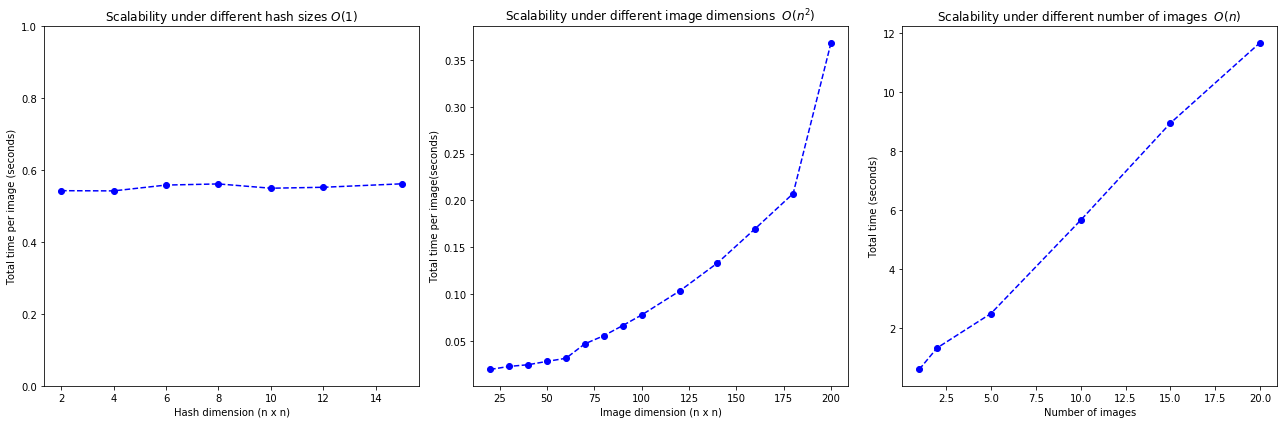

In [91]:
get_scalability_graphs(times_jpgsize, times_hashes, times_imgamt)

## 1.4. Optimizations

### 1.4.1. Cython

In [13]:
import FINd_Cython as fc
findHasher = fc.FINDHasherCython()

In [14]:
test_hash_correctness(findHasher)

The hashing algorithms provide the same output


In [15]:
filepath = './das_images/1034_34813023.jpg'
%timeit findHasher.fromFile(filepath)

14.3 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 1.4.2. Numpy + CV2

#### 1.4.2.1. Evaluate the approach

In [227]:
from FINd_CV2 import FINDHasher
findHasherCV = FINDHasher()
filepath = './das_images/1034_34813023.jpg'


In [220]:
test_hash_correctness(findHasherCV)

AssertionError: At least one of the example hashes do not match

In [176]:
%timeit findHasherCV.fromFile(filepath)

44.6 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 1.4.2.2. Compare the Hamming distances between the approaches

In [17]:
import FINd_Cython as fc
findHasher = fc.FINDHasherCython()

In [11]:
def hash_group(filename):
    """
    Get hash group from a filename
    """
    
    return filename.split('images/')[1][:4]

In [12]:
def get_img_combinations(no_groups=5, path = './das_images/*'):
    """
    Get all combinations of images from the provided path for a pre-specificed number of groups
    """

    # Get files
    files = pd.Series(glob(path))
    
    # Get image categories to extract
    categories = files.map(lambda x: hash_group(x)).value_counts().sort_values(ascending=True)
    get_groups = categories.keys()[0:no_groups]
    
    # Get the actual images and their combinations
    images_to_use = files[files.map(lambda x: hash_group(x) in get_groups)]
    imgs_comb = combinations(images_to_use, 2)
    
    return imgs_comb

In [13]:
@lru_cache(maxsize=None) 
def get_distances_imgs(findHasher, imgs_comb, hash_from_image=False):
    """
    Calculate the distances between the given hashes and return
    the total differences between the same and different hashes.
    
    Caching so that the findHasher.fromFile could retrieve results for the same hashes
    """
    distances_same = []
    distances_dif = []

    for f1, f2 in imgs_comb:
        # get hashes
        
        # Check if the input is from file or image
        if hash_from_image:
            hash1 = findHasher(Image.open(f1))
            hash2 = findHasher(Image.open(f2))
        
        else:
            hash1 = findHasher.fromFile(f1)
            hash2 = findHasher.fromFile(f2)
        
        # Convert to Image Hash type if they're numpy arrays
        if type(hash1) in [np.ndarray, str]:
            hash1 = ImageHash(np.array(hash1))
            hash2 = ImageHash(np.array(hash2))

        # Get differences
        diff_hash = hash2-hash1

        # Get group
        group1 = hash_group(f1)
        group2 = hash_group(f2)

        if group1 == group2: distances_same.append(diff_hash)
        else: distances_dif.append(diff_hash)
            
    return distances_same, distances_dif

In [ ]:
imgs_comb = get_img_combinations(6)
get_distances_imgs.cache_clear() # Clear cache to avoid previous runs results
distances_same, distances_dif = get_distances_imgs(findHasher, imgs_comb)

In [259]:
get_distances_imgs.cache_clear() # Clear Cache for the other algorithm
imgs_comb = get_img_combinations(6)
distances_sameCV, distances_difCV = get_distances_imgs(findHasherCV, imgs_comb)

In [496]:
def get_dataframe_for_boxplot(distances_same, distances_dif, distances_sameCV, distances_difCV):
    """
    Creates a dataframe used for plotting a boxplot to compare the differences
    between the FINd algorithm and the CV2 version of it.
    """
    
    # Extend the lengths of the list to merge to a dataframe (Required for a boxplot)
    n_extend = len(distances_dif) - len(distances_same)
    distances_same_adj = distances_same  + [np.nan for _ in range(n_extend)]
    distances_sameCV_adj = distances_sameCV  + [np.nan for _ in range(n_extend)]
    
    # Create a dataframe with the values
    df = pd.DataFrame()
    df['Initial, different'] = distances_dif
    df['CV2, different'] = distances_difCV
    df['Initial, same'] = distances_same_adj
    df['CV2, same'] = distances_sameCV_adj
    
    # Shape the data to fit a boxplot shape
    df_diff = pd.melt(df)
    df_diff['Algorithm'] = df_diff['variable'].map(lambda x: 'FINd basic' if 'Initial' in x else 'FINd CV2')
    df_diff['Group type'] = df_diff['variable'].map(lambda x: 'Same group' if 'same' in x else 'Different group')
    
    # Drop the NAs and change the data type
    df_diff = df_diff.dropna()
    df_diff['value'] = df_diff['value'].astype(int)
    
    return df_diff

In [261]:
df_diff = get_dataframe_for_boxplot(distances_same, distances_dif, distances_sameCV, distances_difCV)

In [505]:
def get_boxplot_hash_diff(df_diff, savefigure=True, namefig='hash_boxplot.png'):
    """
    Plot the box plots for FINd basic and CV2 algorithms
    """
    fig, ax = plt.subplots(1,1, figsize=(9,6))
    sns.boxplot(x='Group type', y = 'value', data = df_diff, hue = 'Algorithm', palette = 'Set2', ax=ax)
    ax.set_ylabel("Hamming distance between groups")
    
    if savefigure:
        fig.savefig(namefig)

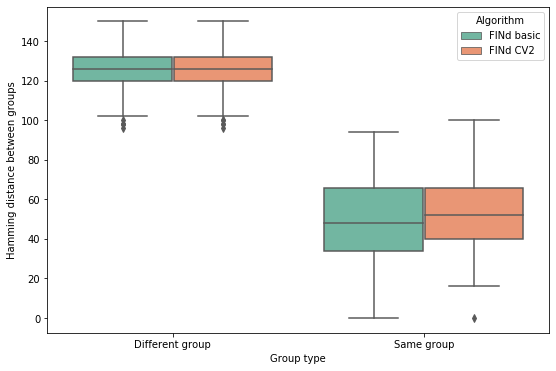

In [265]:
get_boxplot_hash_diff(df_diff, savefigure=True)

### 1.4.3. Spark

Timing generated from $pysparkex.py$ and $FINd\_multiprocessing.py$ under Optimizations/Spark

In [12]:
# Import Spark times
times_cpu = pd.read_json('2021-01-17 spark_cpu_times.json')
times_wallclock = pd.read_json('2021-01-17 spark_wallclock_times.json')

# Import Multiprocessing times
times_cpu_mpc = pd.read_json('2021-01-17 multiprocessing_times_wallclock.json')
times_wallclock_mpc = pd.read_json('2021-01-17 multiprocessing_times_cpu.json')

In [13]:
def get_df_cpu(times_cpu):
    df_cpu = pd.melt(times_cpu.reset_index(), id_vars = 'index')
    df_cpu.columns = ['no_images', 'processor', 'time']
    return df_cpu


In [14]:
df_cpu = get_df_cpu(times_cpu)
df_cpu_mpc = get_df_cpu(times_cpu_mpc)

In [31]:
def plot_cpu_times(df_cpu, df_cpu_mpc, savefigure=True):
    """
    Plot the CPU times for Spark and Multiprocessing
    programs
    """

    fig, axs = plt.subplots(1,2, figsize = (16,6))
        
    total_images = df_cpu.no_images.unique()
    for processor in df_cpu.processor.unique():
        axs[0].plot(total_images, df_cpu.loc[df_cpu.processor == processor, 'time'], label = f'Processor: {processor}')
        axs[1].plot(total_images, df_cpu_mpc.loc[df_cpu_mpc.processor == processor, 'time'], label = f'Processor: {processor}')

    axs[0].set_xscale('log')
    axs[0].set_xlabel("Number of images")
    axs[0].set_ylabel("Time (in seconds)")
    axs[0].set_title("CPU Time for Spark program", fontsize=14)
    axs[0].legend()
    axs[0].grid()

    axs[1].set_xscale('log')
    axs[1].set_xlabel("Number of images")
    axs[1].set_ylabel("Time (in seconds)")
    axs[1].set_title("CPU Time for Multiprocessing program", fontsize=14)
    axs[1].legend()
    axs[1].grid()
    
    if savefigure:
        fig.savefig('cpu_times.png')

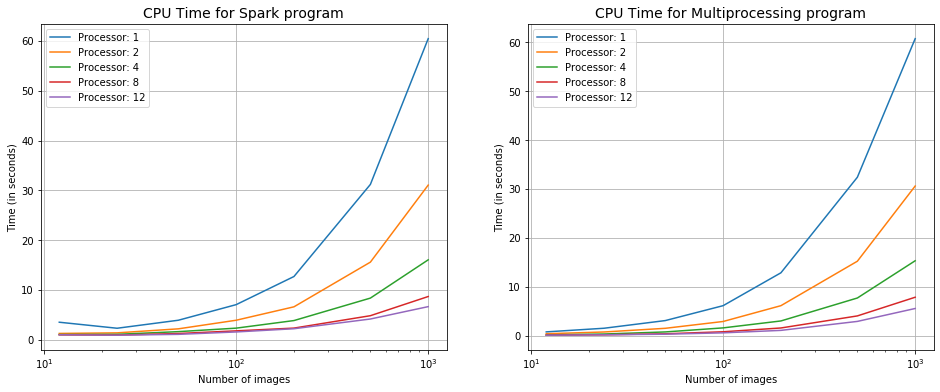

In [32]:
plot_cpu_times(df_cpu, df_cpu_mpc)

# Part 2

In [ ]:
def get_images_in_class():
    """
    Get the number of images in each class
    """
    imgs = pd.Series([x[13:18] for x in glob('./das_images/*')])
    fig, ax = plt.subplots(1,1, figsize = (7,5))

    ax.hist(imgs.value_counts().values, bins = 50)
    ax.set_xlabel("Number of images inside the class")
    ax.set_ylabel("Number of classes")

    fig.savefig('images_in_the_class.png')

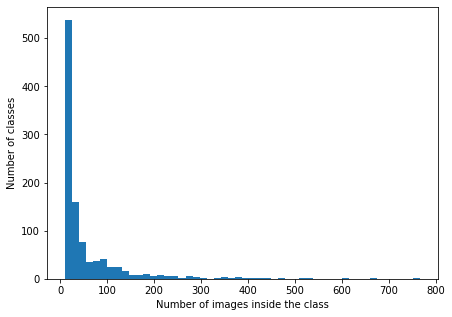

In [491]:
get_images_in_class()

## 2.1. Get the differences between the hashing algorithms

In [507]:
imgs_comb = get_img_combinations(12)
get_distances_imgs.cache_clear() # Clear cache to avoid previous runs results
distances_same_ph, distances_dif_ph = get_distances_imgs(imagehash.phash, imgs_comb, hash_from_image=True)

In [508]:
imgs_comb = get_img_combinations(12)
get_distances_imgs.cache_clear() # Clear cache to avoid previous runs results
distances_same_avg, distances_dif_avg = get_distances_imgs(imagehash.average_hash, imgs_comb, hash_from_image=True)

In [509]:
imgs_comb = get_img_combinations(12)
get_distances_imgs.cache_clear() # Clear cache to avoid previous runs results
distances_same_FINd, distances_dif_FINd = get_distances_imgs(findHasher, imgs_comb)

In [510]:
def get_dataframe_for_boxplot_three_hashes(distances_same, distances_dif, distances_same_ph, distances_dif_ph, distances_same_avg, distances_dif_avg):
    """
    Creates a dataframe used for plotting a boxplot to compare the differences
    between the FINd algorithm and two other variables
    """
    
    # Extend the lengths of the list to merge to a dataframe (Required for a boxplot)
    n_extend = len(distances_dif) - len(distances_same)
    distances_same_adj = distances_same  + [np.nan for _ in range(n_extend)]
    distances_same_ph_adj = distances_same_ph  + [np.nan for _ in range(n_extend)]
    distances_same_avg_adj = distances_same_avg  + [np.nan for _ in range(n_extend)]

    
    # Create a dataframe with the values
    df = pd.DataFrame()
    df['FINd, different'] = distances_dif
    df['Phash, different'] = distances_dif_ph
    df['Average hash, different'] = distances_dif_avg
    df['FINd, same'] = distances_same_adj
    df['Phash, same'] = distances_same_ph_adj
    df['Average hash, same'] = distances_same_avg_adj
    
    # Shape the data to fit a boxplot shape
    df_diff = pd.melt(df)
    df_diff['Algorithm'] = df_diff['variable'].map(lambda x: 'FINd' if 'FINd' in x else 'Phash' if 'Phash' in x else 'Average hash')
    df_diff['Group type'] = df_diff['variable'].map(lambda x: 'Same group' if 'same' in x else 'Different group')
    
    # Drop the NAs and change the data type
    df_diff = df_diff.dropna()
    df_diff['value'] = df_diff['value'].astype(int)
    
    return df_diff

In [511]:
df_hashes_diff = get_dataframe_for_boxplot_three_hashes(distances_same_FINd, distances_dif_FINd, distances_same_ph, distances_dif_ph, distances_same_avg, distances_dif_avg)

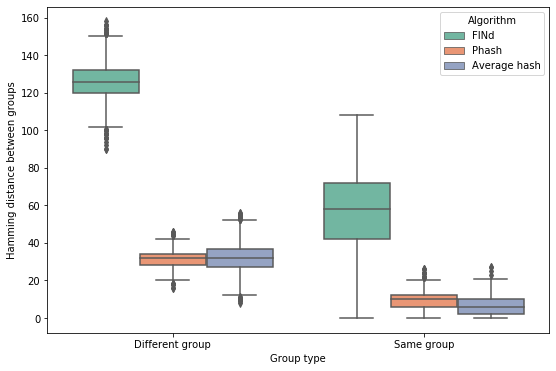

In [512]:
get_boxplot_hash_diff(df_hashes_diff, savefigure=True, namefig = 'boxplot_find_comparison.png')

The relative performance might be different due to different hash sizes. It can be adjusted, if necessary. It is thus compared for each group separately.

## 2.2. Compute a separate threshold for all of the groups

In [516]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

In [517]:
def get_svm_classification(distances_same, distances_dif):
    """
    Get a Support Vector Machine classification model for the provided
    differences (in lists)
    """
    
    # Assign lists to dataframes
    df1 = pd.DataFrame(distances_same)
    df1['type'] = 'same'
    df2 = pd.DataFrame(distances_dif)
    df2['type'] = 'differet'
    
    # Get one dataframe
    df = pd.concat([df1,df2])
    df.columns = ['distance', 'type']
    
    # Create X and Y values
    X = df[['distance']]
    y = df['type']
    y = y.map(lambda x: 0 if 'same' in x else 1)
    
    # Get the data
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X, y)
    
    # Set a new axis
    X = np.array(X)
    
    return svclassifier, np.array(X), np.array(y)

In [539]:
def get_SVM_contour_plots(distances_same_FINd, distances_dif_FINd,
                          distances_same_ph, distances_dif_ph,
                          distances_same_avg, distances_dif_avg):
    
    """
    Computes the optimal SVM classifier for all the three algorithms and outputs
    a plot that shows the linear separation boundary for each
    """
    svmfind, x_find, y_find = get_svm_classification(distances_same_FINd, distances_dif_FINd)
    svmph, x_ph, y_ph = get_svm_classification(distances_same_ph, distances_dif_ph)
    svmavg, x_avg, y_avg = get_svm_classification(distances_same_avg, distances_dif_avg)

    fig, axs = plt.subplots(1,3, figsize = (20,8))
    plot_decision_regions(x_find, y_find, clf = svmfind, legend = 2, ax=axs[0])
    axs[0].set_title("FINd Algorithm Decision boundary", fontsize = 16)

    plot_decision_regions(x_ph, y_ph, clf = svmph, legend = 2, ax=axs[1])
    axs[1].set_title("PHash Algorithm Decision boundary", fontsize = 16)

    plot_decision_regions(x_avg, y_avg, clf = svmavg, legend = 2, ax=axs[2])
    axs[2].set_title("Average Hashing Decision boundary", fontsize = 16)

    for x in range(0,3): axs[x].set_xlabel("Hamming Distance")

    fig.savefig('svm_classification.png')

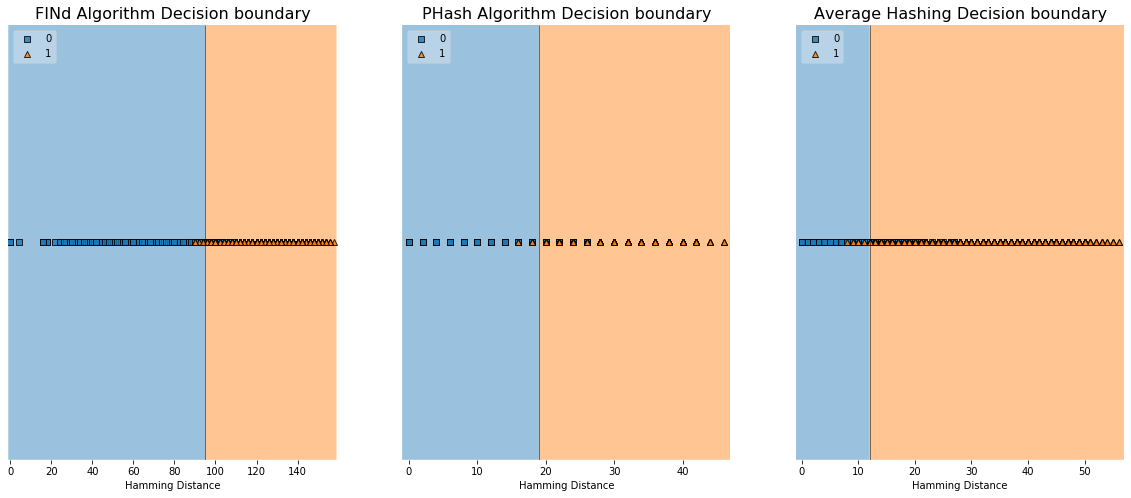

In [540]:
get_SVM_contour_plots(distances_same_FINd, distances_dif_FINd,
                          distances_same_ph, distances_dif_ph,
                          distances_same_avg, distances_dif_avg)

In [522]:
# Set the bounds for classification
bound_find = 94
bound_ph = 19
bound_avg = 12

## 2.3. Computing the difference macro F1-scores

Measurement comparison:
1. Extract 100 groups with 10 images each
2. Compare the 10 images within + with other 20 random images outside
3. Compute the F1 score for each group
4. Get a macro-averaged F1 score.

This enables us to compute the F1 score for more groups given the high group heterogeneity. The reason why F1 is because there is huge class imbalance from the perspective of each group (you'd like to find all (recall) and make sure that each of your individual guesses is correct (precision). This allows to test the hashing algorithm more generally.

In [523]:
def get_images():
    """
    Extract all images from the image folder
    """
    img_groups = pd.Series([i for i in glob('das_images/*.jpg')]).map(
        lambda x: x.split('/')[1])
    return img_groups

imgs = get_images()

In [524]:
def get_sample_img_dataframe(imgs, subset=True, imgs_per_group=10, groups_to_use=100):
    """
    Create a dataframe with a given number of images per group, and a pre-specified
    number of groups. 
    """
    
    # Extract groups
    df = pd.DataFrame(imgs)
    df.columns = ['images']
    df['group'] = df.images.map(lambda x: x[0:4])
    
    if subset:
        # Manipulate dataframe so that only groups and images remain
        df = df.groupby('group').apply(lambda x: x.sample(imgs_per_group))
        df.columns = ['images', 'groupname']
        df = df.reset_index().drop(['group', 'level_1'], axis=1)

        # Get number of groups to use
        groups_unique = set(df.groupname.unique())
        groups_to_use = random.sample(groups_unique, groups_to_use)

        df = df[df.groupname.isin(groups_to_use)].copy()
        
    return df

In [525]:
df = get_sample_img_dataframe(imgs)

In [528]:
df['hash_FINd'] = df['images'].map(lambda x: findHasher.fromFile(f'das_images/{x}'))
df['hash_average'] = df['images'].map(lambda x: imagehash.average_hash(Image.open(f'das_images/{x}')))
df['hash_phash'] = df['images'].map(lambda x: imagehash.phash(Image.open(f'das_images/{x}')))

In [529]:
def get_f1_scores(df, hash_name, bound, no_imgs_not_in_group=20, verbose=False):
    """
    Calculate the F1-scores based on the given data and hashing algorihm. F1 scores
    for each iteration are returned, where each iteration consists of 10 images from a
    single group and 20 images (by default) from another group
    """

    groups = df.groupname.unique()

    f1_scores = []

    for gname in groups:
        
        if verbose: print(f"Processing group {gname}")
        imgs_in_group = list(df.loc[df.groupname == gname, 'images'])
        imgs_not_in_group = list(random.sample(set(df.loc[~(df.groupname == gname),
                                                       'images']), no_imgs_not_in_group))

        all_images = imgs_in_group  + imgs_not_in_group

        # Initialize empty lists
        differences_same = []
        differences_different = []

        for im1, im2 in combinations(all_images, 2):

            # Get hashes
            hash1 = df.loc[df.images == im1, hash_name].iloc[0]
            hash2 = df.loc[df.images == im2, hash_name].iloc[0]

            # Get groups
            group1 = df.loc[df.images == im1, 'groupname'].iloc[0]
            group2 = df.loc[df.images == im2, 'groupname'].iloc[0]

            # Get difference in hashes
            hash_diff = hash2 - hash1

            # Assign values
            if group1 == group2: differences_same.append(hash_diff)
            else: differences_different.append(hash_diff)


        # Calculate the results (differences_same has ground-truth same values;
        # differences_different has ground-truth different values. Predictions are compared
        # to the groundtruth data)

        tp = np.sum(np.array(differences_same) <= bound)
        fp = np.sum(np.array(differences_different) <= bound)
        fn = np.sum(np.array(differences_same) > bound)

        # Calculate F1
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = (2 * precision * recall) / (precision + recall)

        f1_scores.append(f1)
        
    return f1_scores

In [530]:
f1_find = get_f1_scores(df, 'hash_FINd', bound_find)
f1_avg = get_f1_scores(df, 'hash_average', bound_avg)
f1_phash = get_f1_scores(df, 'hash_phash', bound_ph)

In [531]:
print("FINd result: {}".format(np.array(f1_find).mean()))
print("AVG Hashing result: {}".format(np.array(f1_avg).mean()))
print("PHash result: {}".format(np.array(f1_phash).mean()))

FINd result: 0.972754889032013
AVG Hashing result: 0.9047130271367027
PHash result: 0.952582399604999


In [549]:
def plot_f1_scores(f1_find, f1_avg, f1_phash):
    """
    Plot the F1 distribution for the calculated F1 scores
    """
    
    fig, axs = plt.subplots(1,1, figsize = (8,5))

    sns.distplot(np.array(f1_find), ax = axs, kde=False, label = 'FINd Hashing')
    sns.distplot(np.array(f1_avg), ax = axs, kde=False, label = 'Average Hashing')
    sns.distplot(np.array(f1_phash), ax = axs, kde=False, label = 'Perception Hashing')
    axs.legend()
    axs.set_xlabel("F1 score")
    axs.set_ylabel("Number of groups")
    axs.set_title("Comparison of F1-scores for different groups")
    
    fig.savefig('f1_scores.png')

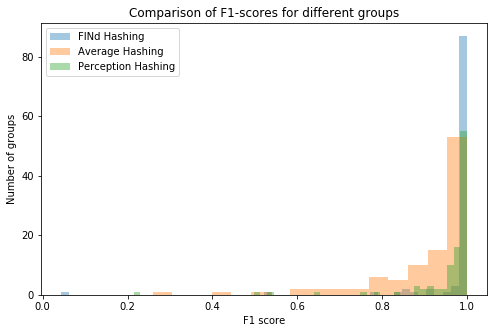

In [550]:
plot_f1_scores(f1_find, f1_avg, f1_phash)

## 2.4. Compare for new hash identification

In [132]:
df = get_sample_img_dataframe(imgs, subset=False)
df_truth = df.groupby('group').apply(lambda x: x.sample(1))

In [145]:
df_truth['hash_FINd'] = df_truth['images'].map(lambda x: findHasher.fromFile(f'das_images/{x}'))
df_truth['hash_average'] = df_truth['images'].map(lambda x: imagehash.average_hash(Image.open(f'das_images/{x}')))
df_truth['hash_phash'] = df_truth['images'].map(lambda x: imagehash.phash(Image.open(f'das_images/{x}')))

# Get dataframe of images not used
df_not_used = df[~df['images'].isin(df_truth['images'])].copy()
images_not_used = set(df_not_used['images'])

# Change the indexing of the truth dataframe
df_truth = df_truth.drop('group', axis = 1).reset_index().drop('level_1', axis = 1)

In [462]:
def simulate_img_inflows(hasher, hash_name, df_truth=df_truth, no_times = 2_000):
    """
    Simulate a random image inflow and compare it to a given meme hash. A classification
    is correct if the shortest distance is the correct one
    """
    
    # Get random image and hash
    correct = 0
    incorrect = 0
    incorrect_log = {}
    
    start_time = time.time()
    for _ in range(no_times):

        img = random.sample(images_not_used, 1)[0]
        hash_ =  hasher(Image.open((f'das_images/{img}')))

        # Get minimum index
        index_min = df_truth[hash_name].map(lambda x: x - hash_).idxmin()

        if img[0:4] == index_min: 
            correct += 1
        else: 
            incorrect +=1

            # Append to incorrect log
            if img in incorrect_log: incorrect_log[img].append([index_min])
            else: incorrect_log[img] = [index_min]
    
    
    # Get the proportion of the classifications that are correct
    prop_correct = correct / (correct + incorrect)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    return prop_correct, incorrect_log, total_time

In [463]:
prop_correct_find, incorrect_log_find, time_find = simulate_img_inflows(findHasher.fromImage, 'hash_FINd', no_times = 15_000)
prop_correct_avg, incorrect_log_avg, time_avg = simulate_img_inflows(imagehash.average_hash, 'hash_average', no_times = 15_000)
prop_correct_phash, incorrect_log_phash, time_phash = simulate_img_inflows(imagehash.phash, 'hash_phash', no_times = 15_000)

In [464]:
print("Proportion of FINd Hashing that is correct {}".format(prop_correct_find))
print("Proportion of Average Hashing that is correct {}".format(prop_correct_avg))
print("Proportion of PHashing that is correct {}".format(prop_correct_phash))

Proportion of FINd Hashing that is correct 0.8528666666666667
Proportion of Average Hashing that is correct 0.7130666666666666
Proportion of PHashing that is correct 0.7808


In [418]:
def generate_plot_sequence(incorrect_log):
    """
    Generates a sequence for plotting items, correct versus incorrect
    guesses
    """
    items_to_plot = random.sample(list(incorrect_log.items()), 8)

    item_sequence = []
    for guess_img, truth_group in items_to_plot:
        truth_img = df_truth.loc[df_truth.index == truth_group[0], 'images'].iloc[0]
        item_sequence.append(guess_img)
        item_sequence.append(truth_img)
        
    return item_sequence

In [574]:
def plot_incorrect_items(item_sequence, savefigure=False, name=None):
    """
    Plots a sequence of items that are incorrect predictions based on the
    closest hashing algorithm
    """
    
    # Set variables for counting the number of the image example
    counter1 = 1
    counter2 = 1
    
    # Plot the images
    fig, axs = plt.subplots(4,4, figsize = (24,24))

    for i, ax in enumerate(axs.flatten()):
        image_name = item_sequence[i]
        im = Image.open(f'das_images/{image_name}')
        
        ax.imshow(im)
        if i % 2 == 0:
            ax.set_title(f"Guess image {counter1}: {image_name}", fontsize = 16)
            counter1 += 1
        else: 
            ax.set_title(f"Truth image {counter2}: {image_name}", fontsize = 16)
            counter2 += 1
            
    if savefigure:
        fig.savefig(name)

The images below display the "guess" image and the "truth" image one next to each other. 

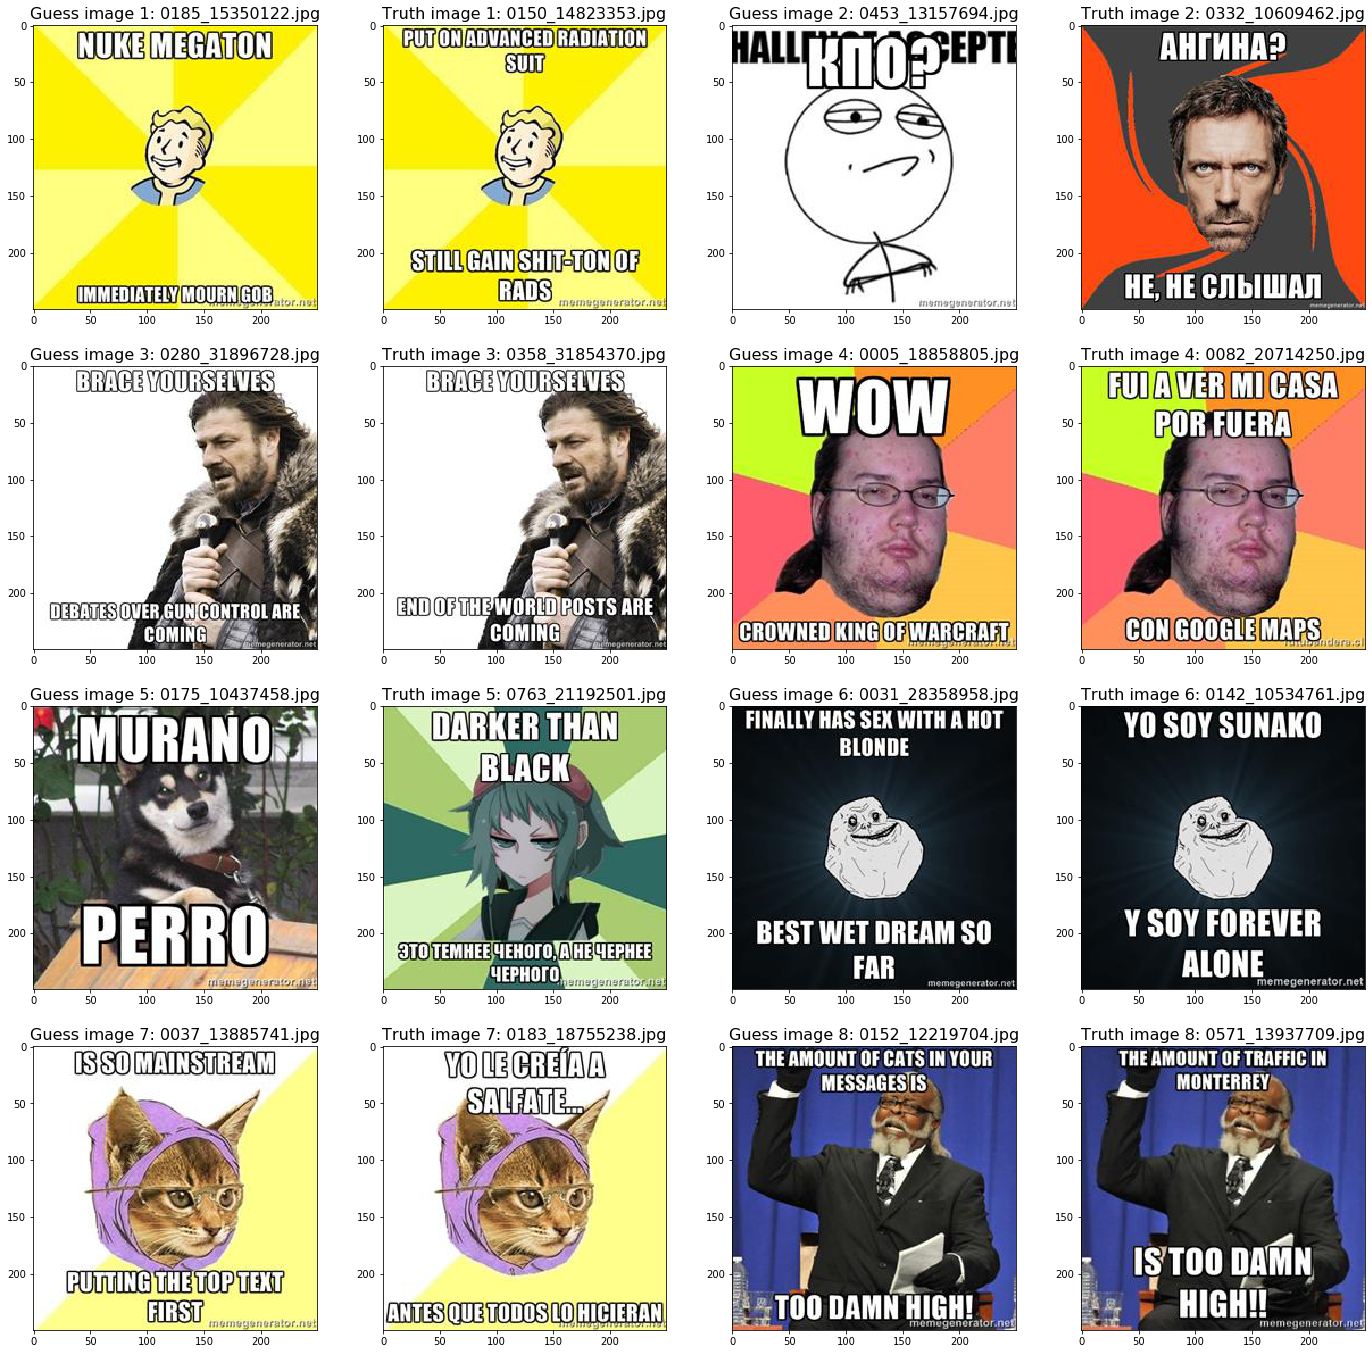

In [576]:
items_sequence_find = generate_plot_sequence(incorrect_log_find)
plot_incorrect_items(items_sequence_find, savefigure=True, name='find_incorrect_guesses.png')

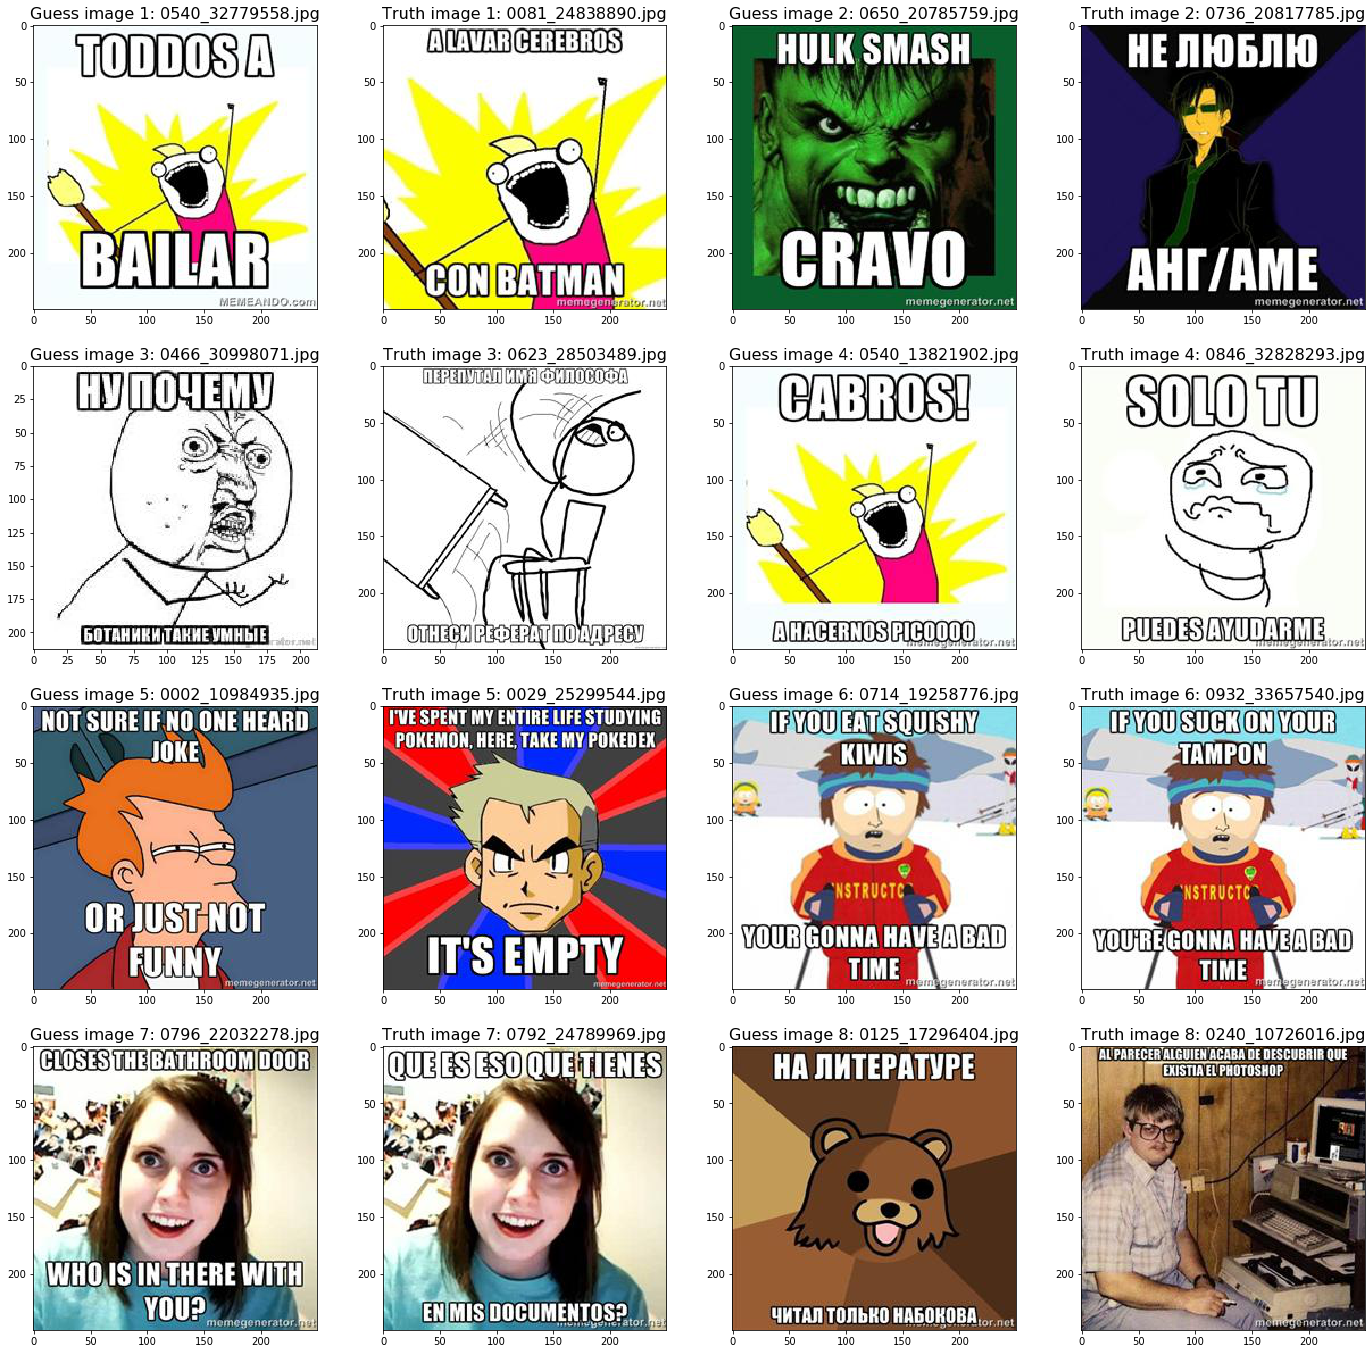

In [577]:
items_sequence_avg = generate_plot_sequence(incorrect_log_avg)
plot_incorrect_items(items_sequence_avg, savefigure=True, name='avg_incorrect_guesses.png')

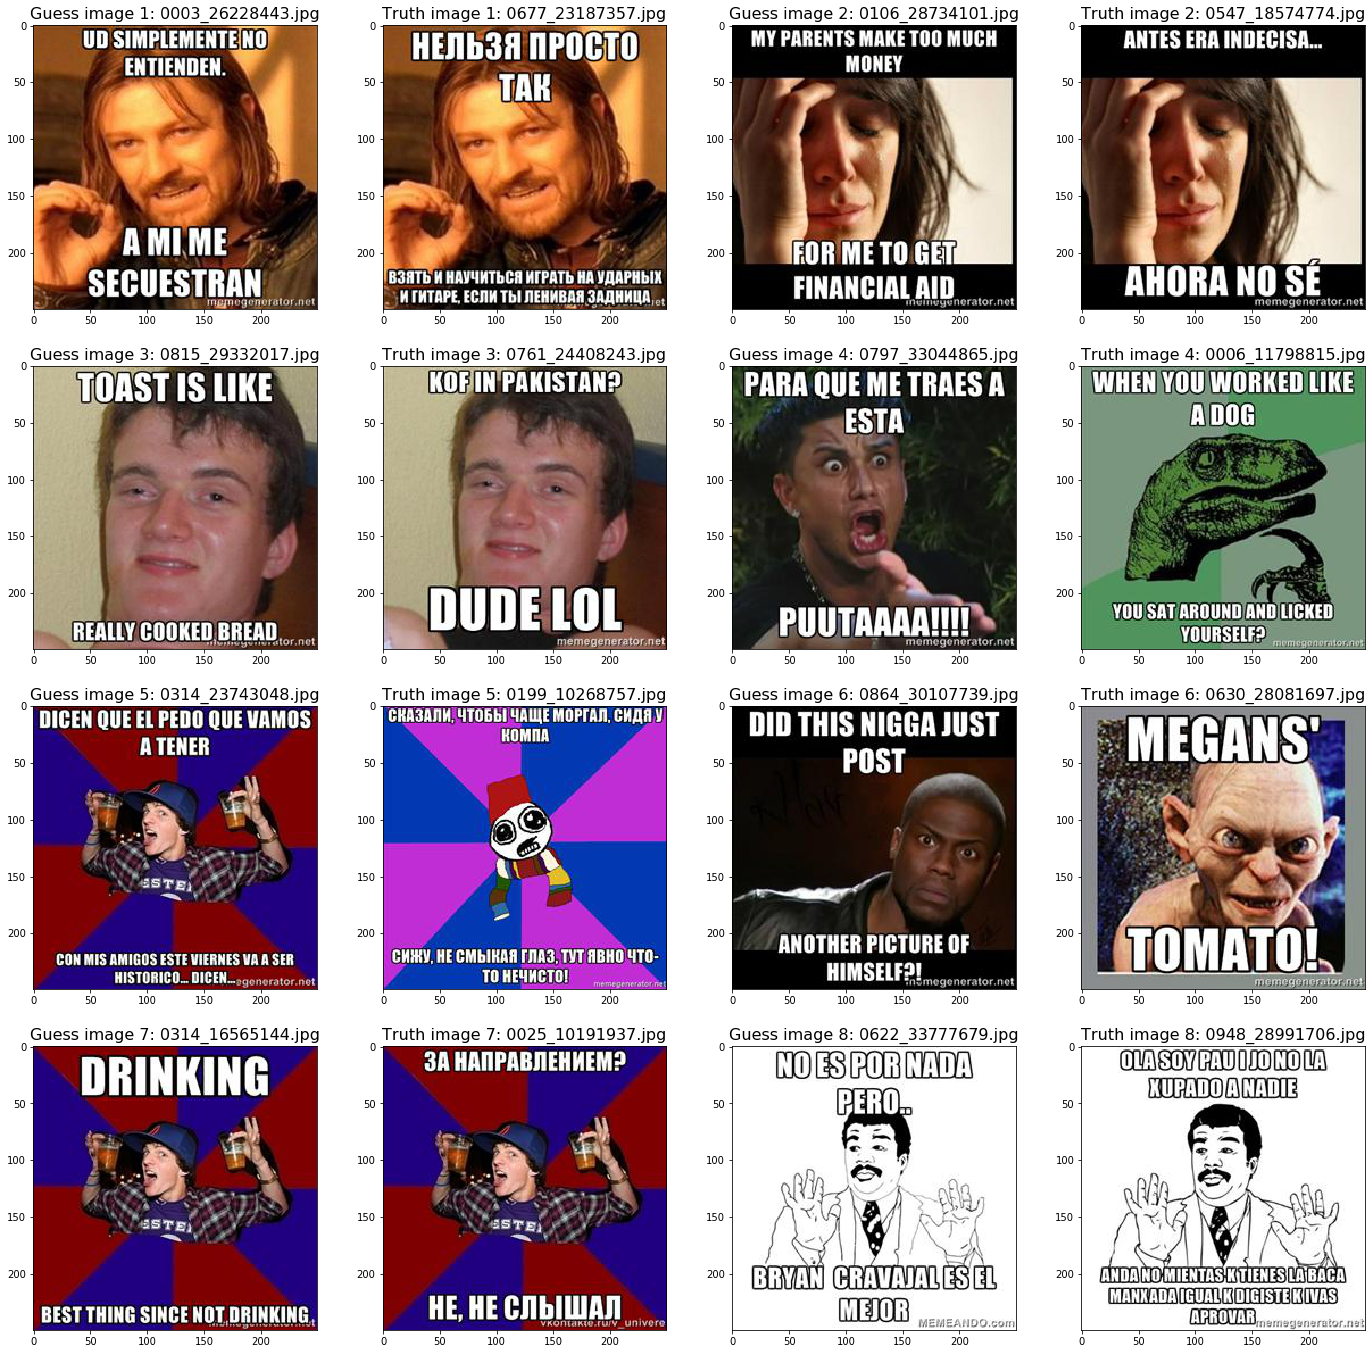

In [578]:
items_sequence_phash = generate_plot_sequence(incorrect_log_phash)
plot_incorrect_items(items_sequence_phash, savefigure=True, name='phash_incorrect_gueses.png')

## 2.5. Comparing the timing of the hashing algorithms

Times for a certain number of images

In [475]:
# Get arbitrary one image
img = './das_images/' + imgs[0]

In [476]:
%timeit findHasher.fromImage(Image.open(img))

14.6 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [477]:
%timeit imagehash.average_hash(Image.open(img))

1.74 ms ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [479]:
%timeit imagehash.phash(Image.open(img))

2.04 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
